### **Fine-Tuning Encoder-Only Language Models for Multi-Label Email Intent Classification**

**Project Description**

This project implements a multi-label email intent classification system using pretrained encoder-only Transformer models (BERT, RoBERTa, DeBERTa). Unlike traditional single-label classification, each email can belong to multiple intent categories simultaneously, requiring a sigmoid-based multi-label prediction head and threshold calibration.

The model will be fine-tuned using a parameter-efficient approach (PEFT/LoRA) to reduce computational cost while maintaining high accuracy. Training will utilize `BCEWithLogitsLoss`, per-label threshold tuning, and standard multi-label evaluation metrics such as Micro/Macro F1-score.

The notebook includes:
- Data preprocessing and tokenization

- Model architecture with multi-label classification head

- PEFT/LoRA fine-tuning for encoder-only transformers

- Threshold tuning and performance evaluation

- Inference pipeline for real-world email intent prediction


**Objectives**

- Train an accurate and efficient multi-label classifier for email intent detection

- Compare baseline ML models vs Transformer-based approaches

- Optimize training using parameter-efficient fine-tuning (LoRA)

- Evaluate using micro/macro F1 and per-label performance

- Deploy a reproducible inference pipeline

**Expected Outcome**

A robust intent classifier capable of predicting multiple intents per email with high semantic accuracy and low training overhead.



#### **1. Set Up**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
import torch 
import gc

import json
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model

from collections import Counter
import os

In [2]:
# Device setup for MPS 
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" # Fallback for missing MPS

# Set MPS as the default device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: mps


In [3]:
# Read the dataset
dataset = load_dataset("imnim/multiclass-email-classification")

#### **2. Data Understanding**

In [4]:
# Check the dataset
print("Dataset: \n", dataset)
print("="*50)
print(f"Dataset Shape: Rows-{dataset['train'].num_rows}, Columns-{len(dataset['train'].column_names)}")
print("="*50)
print("Sample Data: \n", dataset['train'][:3])

Dataset: 
 DatasetDict({
    train: Dataset({
        features: ['subject', 'body', 'labels'],
        num_rows: 2105
    })
})
Dataset Shape: Rows-2105, Columns-3
Sample Data: 
 {'subject': ['Meeting Reminder: Quarterly Sales Review Tomorrow', 'Meeting Confirmation for Tomorrow', 'Important Update: New Company Policies'], 'body': ['Dear Team, Just a friendly reminder that our Quarterly Sales Review meeting is scheduled for tomorrow at 10:00 AM in the conference room. Please make sure to bring your sales reports and any relevant updates. Coffee and pastries will be provided. Looking forward to a productive meeting. Best regards, [Your Name]', "Dear Team, This is just a friendly reminder that our weekly team meeting is scheduled for tomorrow at 10:00 AM in the conference room. Please make sure to come prepared with updates on your current projects. If you have any topics you'd like to discuss, feel free to email them to me before the meeting. Looking forward to a productive session. Bes

**Note:** This dataset is a multi-label emails dataset that contains subject, body, and labels in each email instance. From the first few samples of the dataset, we can see that:

- For each email, there may be more than one email classes that it belongs to, making it a multi-class classification task. 

- The subject and body are not in the same text body, so we need to merge these together into one text like the whole email for training the model. 

- We need to apply preprocessing as well to the text email as there are some placeholders like `[Your Name]` in the email body since this dataset was synthetically created by a machine not real-world dataset. 

In [5]:
# Check the class distribution
train = dataset["train"]
label_lists = train["labels"]

# Normalize the labels
norm_labels = [ls if isinstance(ls, list) else [ls] for ls in label_lists]
all_labels = [l for ls in norm_labels for l in ls]

# Count the number of emails for each class
label_counts = Counter(all_labels)

# Convert to DataFrame
dist_df = (
    pd.DataFrame({"label": list(label_counts.keys()), "count": list(label_counts.values())})
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)
dist_df["pct"] = dist_df["count"] / len(train) * 100

dist_df.head()

,label,count,pct
0,Business,941,44.703088
1,Events & Invitations,656,31.163895
2,Reminders,343,16.294537
3,Finance & Bills,334,15.866983
4,Travel & Bookings,314,14.916865


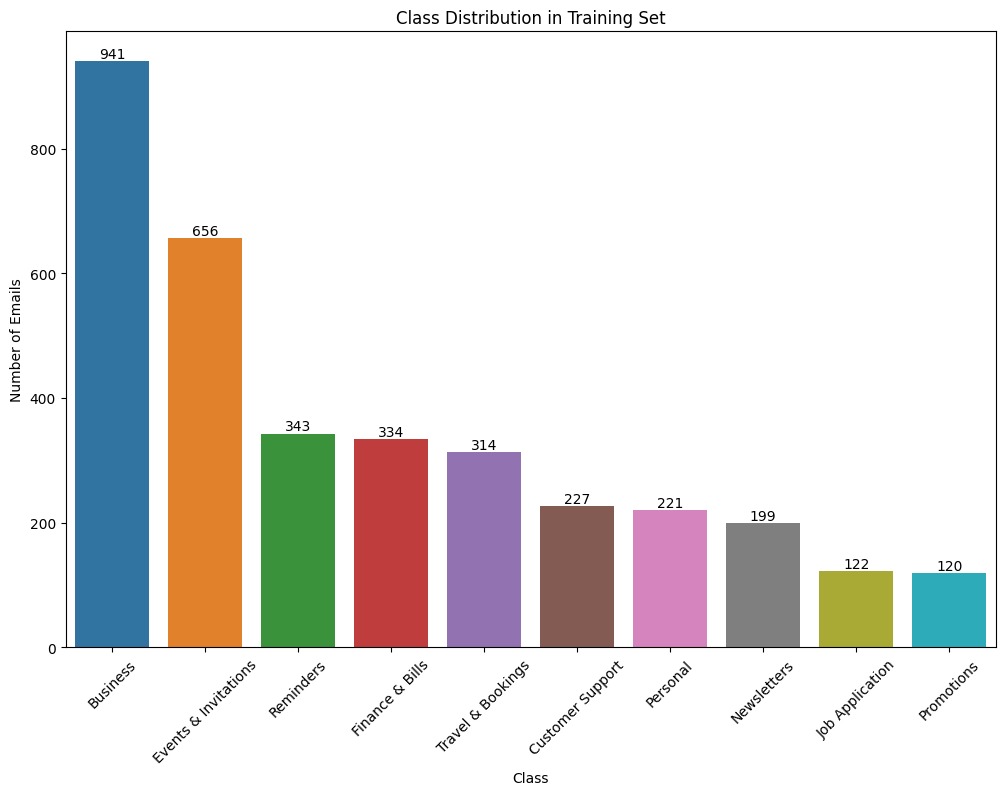

In [6]:
# Plot the class distribution
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="label", y="count", data=dist_df, hue="label")

# Add text labels above bars
for container in ax.containers:
    ax.bar_label(container)

plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Emails")
plt.xticks(rotation=45)
plt.show()

In [7]:
# Check the top 10 most common label lists in email
data_tuple = [tuple(sublist) for sublist in train["labels"]]
label_list_counts = Counter(data_tuple)

# Sort the label lists by count
sorted_label_lists = sorted(label_list_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 most common label lists
top_10_label_lists = sorted_label_lists[:10]
print(top_10_label_lists)

[(('Business', 'Events & Invitations'), 355), (('Travel & Bookings',), 266), (('Finance & Bills',), 222), (('Business', 'Reminders'), 174), (('Personal',), 113), (('Job Application',), 105), (('Business', 'Customer Support'), 103), (('Newsletters',), 103), (('Promotions',), 102), (('Business', 'Events & Invitations', 'Reminders'), 82)]


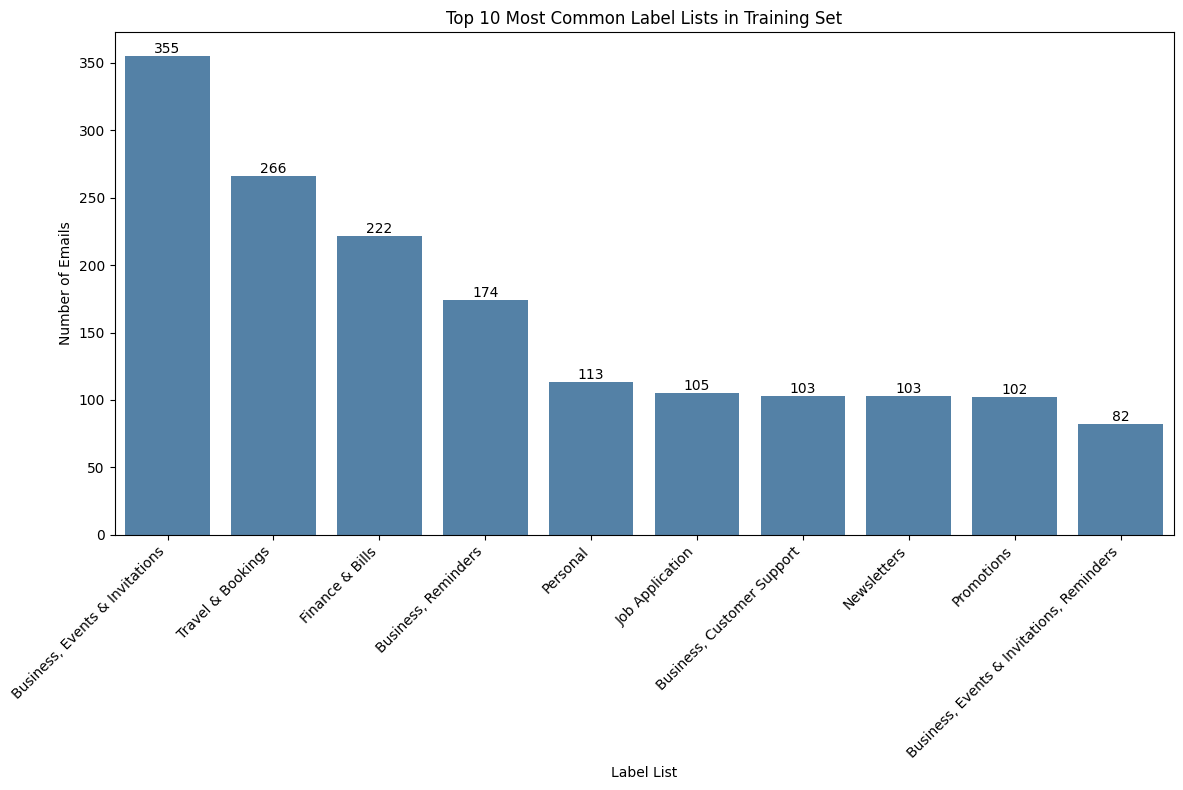

In [8]:
# Convert tuple labels to readable strings
top_10_label_lists_df = pd.DataFrame(top_10_label_lists, columns=["label", "count"])
top_10_label_lists_df["label_str"] = top_10_label_lists_df["label"].apply(lambda t: ", ".join(t))

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="label_str", y="count", data=top_10_label_lists_df, color="steelblue") 
for c in ax.containers:
    ax.bar_label(c)

plt.title("Top 10 Most Common Label Lists in Training Set")
plt.xlabel("Label List")
plt.ylabel("Number of Emails")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Note (Class Imbalance):**

- The dataset is imbalanced: some labels appear much more often than others.

- The most frequent single labels are `Business` and `Events & Invitations`.

- The most common label combination is `[Business, Events & Invitations]` (355 emails).

- This imbalance can bias the model toward frequent labels and hurt performance on rare labels.

To mitigate during fine-tuning:

- Use `BCEWithLogitsLoss` with per-label `pos_weight` computed from label frequencies.

- Tune per-label decision thresholds and report macro metrics ( macro F1).

- Optionally use iterative stratification for splits and/or class-balanced sampling.

Missing subject: 0
Missing body: 0
Duplicate texts: 1
Char length percentiles: {0.5: 432.0, 0.9: 516.0, 0.95: 537.0, 0.99: 577.96}


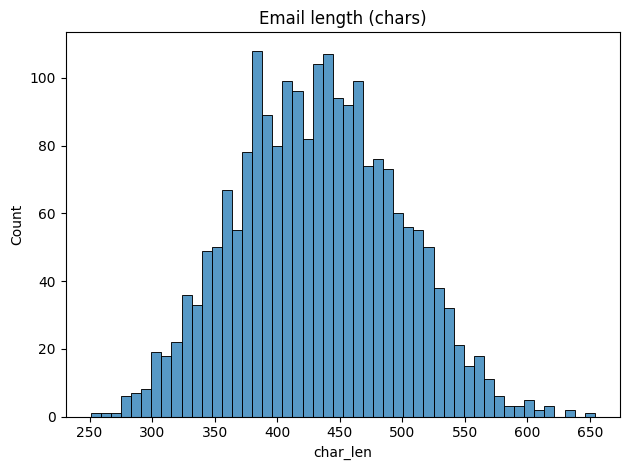

In [9]:
# Check for missing values, duplicates, and text length
df = dataset["train"].to_pandas()
df["text"] = df["subject"].fillna("") + " " + df["body"].fillna("")
df["char_len"] = df["text"].str.len()

print("Missing subject:", df["subject"].isna().sum())
print("Missing body:", df["body"].isna().sum())
print("Duplicate texts:", df["text"].duplicated().sum())
print("Char length percentiles:", df["char_len"].quantile([0.5, 0.9, 0.95, 0.99]).to_dict())

sns.histplot(df["char_len"], bins=50)
plt.title("Email length (chars)")
plt.tight_layout()
plt.show()

**Note (Data checks and tokenization implications): **

- **Data checks**: No missing `subject`/`body`; found **1 duplicate**.

- **Length distribution**: Emails are short–medium (≈250–650 chars), centered around ~450 chars; no extreme long tail.

- **Tokenization choices**:

  - Merge `subject` + `body` .
  - Light cleanup only (remove placeholders like `[Your Name]`); keep casing if using a cased model.

  - Set `max_length` from the 90–95th percentile of tokenized lengths (likely ~256–320; cap at 512).

  - Use `truncation=True` and a dynamic padding collator (faster than fixed `padding='max_length'`).

In [10]:
# Check for label cardinality and desnsity 
norm_labels = [ls if isinstance(ls, list) else [ls] for ls in dataset["train"]["labels"]]
num_labels = len({l for ls in norm_labels for l in ls})
cardinality = np.mean([len(ls) for ls in norm_labels])
density = cardinality / num_labels
print(f"Label cardinality: {cardinality:.3f}, density: {density:.3f}, num_labels: {num_labels}")

Label cardinality: 1.652, density: 0.165, num_labels: 10


**Note:** To understand more about the dataset, we need to check the label cardinality and density,

- `Label Cardinality` tells us about the average number of labels assigned per example of email. For instance, if the cardinality is 2, this means that there are 2 labels per email. 

- `Density` tells us the avearge probability that a randomly chosen label is "on" for a random example. For instance, 

- In our dataset,  the numbers mean:

    - Cardinality = 1.652: Each email has about 1–2 labels on average.

    - num_labels = 10: There are 10 possible labels.

    - Density = 0.165: You have 10 possible labels. Density = 0.165 means that, on average, 16.5% of those 10 are “on” for any given email → about 1.65 labels per email.

- **Implication**: 

    - Modeling: Use sigmoid + BCEWithLogitsLoss (not softmax)

        - Why: Multiple labels can be true at once. Softmax forces probabilities to compete and sum to 1 (single-label assumption), which would suppress co-occurring labels. Sigmoid treats each of the 10 labels as its own on/off probability.

    - Decision thresholds: Use per-label thresholds; avoid fixed top-k

        - Why: The true number of labels varies per email (avg 1.65, not a fixed k). A single 0.5 threshold often under-predicts rare labels and over-predicts frequent ones. Calibrating a separate threshold per label on the validation set (maximizing F1) aligns predicted positives with each label’s prevalence and your overall cardinality.

    - Class imbalance handling: Use per-label pos_weight in BCE

        - Why: With density 0.165, negatives vastly outnumber positives. Unweighted BCE can be minimized by predicting “almost all zeros,” harming recall on rare labels. 

    - Evaluation: Favor macro metrics and PR curves

        - Why: Micro-averaged metrics are dominated by frequent labels and can look strong even if rare labels are ignored. Macro F1 gives each label equal weight. Precision–Recall curves reflect performance under class imbalance better than ROC.

    - Data splitting: Use iterative stratification and deduplicate first

        - Why: You want train/val/test splits that preserve label frequencies and co-occurrences so the calibrated thresholds remain valid. Deduplicating before splitting prevents identical emails from leaking across splits, which would inflate metrics.

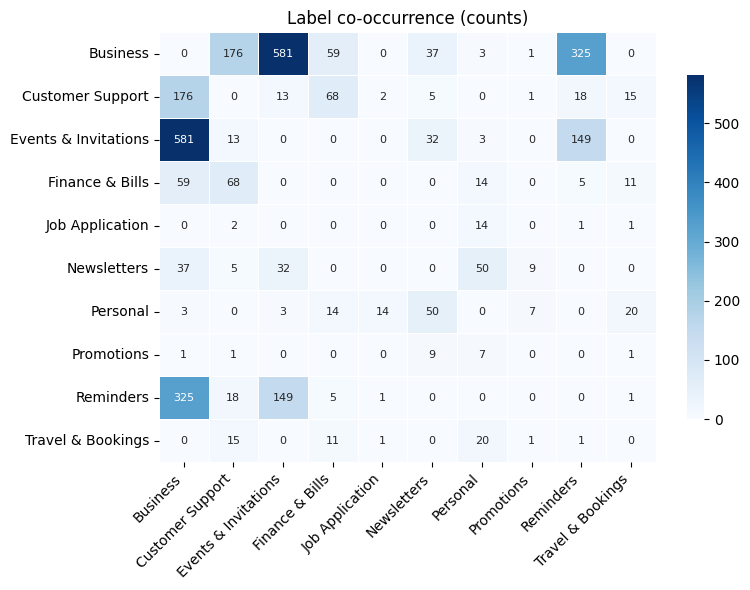

In [11]:
# Check for label co-occurrence heatmap (counts)
labels = sorted(list({l for ls in norm_labels for l in ls}))
idx = {l: i for i, l in enumerate(labels)}
Y = np.zeros((len(norm_labels), len(labels)), dtype=int)
for r, ls in enumerate(norm_labels):
    for l in ls:
        Y[r, idx[l]] = 1

cooc = Y.T @ Y
np.fill_diagonal(cooc, 0)
cooc_df = pd.DataFrame(cooc, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    cooc_df,
    cmap="Blues",
    annot=True,          
    fmt="d",             
    annot_kws={"size":8},
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink":0.8}
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Label co-occurrence (counts)")
plt.tight_layout()
plt.show()

**Note (Label co‑occurrence)**

- Strong pairs:

  - `Business` ↔ `Events & Invitations` (≈581)

  - `Business` ↔ `Reminders` (≈325)

  - `Business` ↔ `Customer Support` (≈176)

  - `Events & Invitations` ↔ `Reminders` (≈149)

- Moderate pairs:

  - `Personal` ↔ `Newsletters` (≈50), `Finance & Bills` ↔ `Newsletters` (≈32),

    `Personal` ↔ `Travel & Bookings` (≈20), `Customer Support` ↔ `Travel & Bookings` (≈15)
    
- Most other pairs are near zero → co‑occurrence is sparse. `Business` behaves like an umbrella tag that frequently appears with other intents.

In [12]:
# Check for rare labels (tune threshold/weights later)
rare = dist_df[dist_df["count"] < 50]
display(rare)

,label,count,pct


**EDA Conclusion:** Based on the data understanding above, we have found that,

- **Goals**

  - Merge `subject` + `body` into a single training text.

  - Prevent leakage; preserve label distribution and co‑occurrence.

  - Prepare clean, tokenized inputs for Transformer training.

- **Steps**
  1) **Data integrity**

     - Check for missing fields; normalize whitespace; remove synthetic placeholders (e.g., `[Your Name]`, `[Date]`, `[Time]`).

  2) **Text construction**

     - Build `text = subject + SEP + body` (conceptually using the tokenizer’s `sep_token`).

  3) **Deduplication (before splitting)**

     - Drop exact duplicate `text`. If duplicates have different labels, union the labels for that text.

  4) **Label space definition**

     - Create a canonical, sorted label list and mappings (`label2id`, `id2label`) to keep label order consistent.

  5) **Multi‑hot targets**

     - Convert each example’s labels to a multi‑hot vector aligned to the canonical label order.

  6) **Stratified splitting**

     - Use multi‑label iterative stratification to create train/val/test splits that preserve per‑label frequencies and common co‑occurrences.

  7) **Token length profiling**

     - Measure token length percentiles on training texts; choose `max_length` near the 90–95th percentile (cap at 512).

  8) **Tokenization configuration**

     - Enable truncation; use dynamic padding; keep casing consistent with the model; set the chosen `max_length`.

  9) **Imbalance handling (light)**

     - Even without rare labels, overall density is low. Prepare mild per‑label `pos_weight` for `BCEWithLogitsLoss` (clamp if needed).

  10) **Metadata persistence**

      - Save `model_name`, `max_length`, label mappings, and split indices for reproducibility.

  11) **Sanity checks**

      - After splitting, re‑check label counts, cardinality/density, and key co‑occurrences; confirm truncation rate is acceptable; ensure no duplicates appear across splits.

- **Outputs**

  - Cleaned, deduplicated train/val/test datasets with multi‑hot labels, tokenizer settings (`max_length`, truncation, padding), and saved preprocessing metadata for consistent training and inference.

#### **3. Data Preprocessing**

In [13]:
# Define a configuration 
MODEL_NAME = "distilbert-base-uncased"
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1
PLACEHOLDERS = ["[Your Name]", "[Date]", "[Time]"]

In [14]:
# Minimal cleanup: remove synthetic placeholders, normalize whitespace
def clean_text(text):
    text = (text or "").strip()
    for p in PLACEHOLDERS:
        text = text.replace(p, "")
    
    return " ".join(text.split())


# Helper function to merge labels
def as_list(x):
    if isinstance(x, str):
        return [x]
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, (list, tuple, set)):
        return list(x)
    return [x]
    

# If duplicates share text but differ in labels, union their labels to keep all signals
def merge_labels(label_lists):
    merged = set()
    for labels in label_lists:
        merged.update(labels if isinstance(labels, list) else [labels])
    return sorted(merged)

In [15]:
# Convert HF dataset to pandas
raw_df = dataset["train"].to_pandas()
raw_df.head()

,subject,body,labels
0,Meeting Reminder: Quarterly Sales Review Tomorrow,"Dear Team, Just a friendly reminder that our Q...","[Business, Reminders]"
1,Meeting Confirmation for Tomorrow,"Dear Team, This is just a friendly reminder th...","[Business, Events & Invitations]"
2,Important Update: New Company Policies,"Dear Team, I hope this email finds you well. I...",[Business]
3,Important Update: Project Deadline Extension,"Dear Team, I hope this message finds you well....","[Business, Reminders]"
4,Monthly Finance Report,"Dear Team, Please find attached the monthly fi...","[Business, Finance & Bills]"


In [16]:
# Clean subject and body fields
raw_df["subject"] = raw_df["subject"].apply(clean_text)
raw_df["body"] = raw_df["body"].apply(clean_text)
raw_df["labels"] = raw_df["labels"].apply(as_list)

# Create a simple join for deduplication (subject + body)
raw_df["text_for_dedup"] = (raw_df["subject"] + " " + raw_df["body"]).str.strip()

print("Rows before cleaning:", len(raw_df))
raw_df.head(3)

Rows before cleaning: 2105


,subject,body,labels,text_for_dedup
0,Meeting Reminder: Quarterly Sales Review Tomorrow,"Dear Team, Just a friendly reminder that our Q...","[Business, Reminders]",Meeting Reminder: Quarterly Sales Review Tomor...
1,Meeting Confirmation for Tomorrow,"Dear Team, This is just a friendly reminder th...","[Business, Events & Invitations]","Meeting Confirmation for Tomorrow Dear Team, T..."
2,Important Update: New Company Policies,"Dear Team, I hope this email finds you well. I...",[Business],Important Update: New Company Policies Dear Te...


In [17]:
# Group by exact text, keep one row, and union labels across duplicates
agg_df = (
    raw_df.groupby("text_for_dedup", as_index=False)
          .agg({
              "subject": "first",
              "body": "first",
              "labels": merge_labels,
          })
)
print(f"Original rows: {len(raw_df):,} | After dedup/group: {len(agg_df):,}")
agg_df.head(3)

Original rows: 2,105 | After dedup/group: 2,104


,text_for_dedup,subject,body,labels
0,Action Required: Update Your Account Informati...,Action Required: Update Your Account Information,"Dear valued customer, We are reaching out to r...","[Customer Support, Reminders]"
1,Confirmation of Business Meeting Dear [Recipie...,Confirmation of Business Meeting,"Dear [Recipient], I hope this email finds you ...","[Business, Events & Invitations]"
2,Confirmation of Dinner Reservation Dear Mr. Sm...,Confirmation of Dinner Reservation,"Dear Mr. Smith, We are pleased to confirm your...",[Events & Invitations]


In [18]:
# Map labels to multi-hot vectors
all_labels = sorted({l for ls in agg_df["labels"] for l in ls}) # Get all unique labels
label2id = {l:i for i,l in enumerate(all_labels)}
id2label = {i:l for l,i in label2id.items()}

# Check the label mapping
print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

Label to ID mapping: {'Business': 0, 'Customer Support': 1, 'Events & Invitations': 2, 'Finance & Bills': 3, 'Job Application': 4, 'Newsletters': 5, 'Personal': 6, 'Promotions': 7, 'Reminders': 8, 'Travel & Bookings': 9}
ID to Label mapping: {0: 'Business', 1: 'Customer Support', 2: 'Events & Invitations', 3: 'Finance & Bills', 4: 'Job Application', 5: 'Newsletters', 6: 'Personal', 7: 'Promotions', 8: 'Reminders', 9: 'Travel & Bookings'}


In [19]:
# Convert each email's labels into a fixed-order multi-hot vector
def to_multi_hot(ls):
    v = [0]*len(all_labels) # Initialize a vector of zeros with length equal to the number of all unique labels
    for l in ls:
        v[label2id[l]] = 1 # Set the index of the label to 1
    return v

multi_hot = [to_multi_hot(ls) for ls in agg_df["labels"]]

# Check the first few multi-hot vectors
print("First 3 multi-hot vectors:")
print(multi_hot[:3])
print("="*50)
print("Actual labels for the first 3 emails:")
print(agg_df["labels"][:3])

First 3 multi-hot vectors:
[[0, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]
Actual labels for the first 3 emails:
0       [Customer Support, Reminders]
1    [Business, Events & Invitations]
2              [Events & Invitations]
Name: labels, dtype: object


In [20]:
# Initialize random seed for reproducibility
np.random.seed(SEED)
indices = np.arange(len(agg_df))
Y = np.array(multi_hot, dtype=int)

In [21]:
# Use multilabel iterative stratification to preserve label distribution and co-occurrence
try:
    # Split Train+Val vs Test using label-aware stratification
    msss_1 = MultilabelStratifiedShuffleSplit(test_size=TEST_SIZE, random_state=SEED)
    trainval_idx, test_idx = next(msss_1.split(indices, Y))

    # Split Train vs Val inside Train+Val (also label-aware)
    msss_2 = MultilabelStratifiedShuffleSplit(test_size=VAL_SIZE, random_state=SEED)
    rel = indices[trainval_idx]           # rows that are in Train+Val
    Y_rel = Y[trainval_idx]               # labels for Train+Val
    tr_rel, va_rel = next(msss_2.split(rel, Y_rel))

    # Final row indices
    train_idx = rel[tr_rel]
    val_idx = rel[va_rel] 
except Exception:
    # Fallback: use regular random splits
    trainval_idx, test_idx = train_test_split(
        indices, test_size=TEST_SIZE, random_state=SEED, shuffle=True
    )

    # Train and val
    train_idx, val_idx = train_test_split(
        trainval_idx, test_size=VAL_SIZE, random_state=SEED, shuffle=True
    )

train_df = agg_df.iloc[train_idx].reset_index(drop=True)
val_df   = agg_df.iloc[val_idx].reset_index(drop=True)
test_df  = agg_df.iloc[test_idx].reset_index(drop=True)

In [22]:
# Check the split results
print(f"Train+Val rows: {len(trainval_idx)} | Test rows: {len(test_idx)}")
print(f"Train rows: {len(train_idx)} | Val rows: {len(val_idx)}")
print(f"Test rows: {len(test_idx)}")

Train+Val rows: 1684 | Test rows: 420
Train rows: 1516 | Val rows: 168
Test rows: 420


In [23]:
# Apply tokenization 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) 

# Build final text with tokenizer seperator
def build_text_row(row):
    sep = tokenizer.sep_token if tokenizer.sep_token else " "
    return (row["subject"] + f" {sep} " + row["body"]).strip()

train_texts = [build_text_row(row) for _, row in train_df.iterrows()]

In [24]:
# Estimate token lengths without truncation to choose max_length
train_token_lengths = [len(tokenizer(t, add_special_tokens=True, truncation=False)["input_ids"]) for t in train_texts]
p90 = int(np.percentile(train_token_lengths, 90))
p95 = int(np.percentile(train_token_lengths, 95))
max_length = min(512, max(256, p95))
print({"p90_tokens": p90, "p95_tokens": p95, "max_length": max_length})

{'p90_tokens': 104, 'p95_tokens': 108, 'max_length': 256}


In [25]:
# Define the tokenizer function
def tokenize_texts(texts):
    return tokenizer(texts, truncation=True, max_length=max_length)

val_texts  = [build_text_row(r) for _, r in val_df.iterrows()]
test_texts = [build_text_row(r) for _, r in test_df.iterrows()]

train_enc = tokenize_texts(train_texts)
val_enc   = tokenize_texts(val_texts)
test_enc  = tokenize_texts(test_texts)

train_enc["labels"] = [to_multi_hot(ls) for ls in train_df["labels"]]
val_enc["labels"]   = [to_multi_hot(ls) for ls in val_df["labels"]]
test_enc["labels"]  = [to_multi_hot(ls) for ls in test_df["labels"]]

In [26]:
# Build HF dataset
train_hf = Dataset.from_dict(train_enc)
val_hf   = Dataset.from_dict(val_enc)
test_hf  = Dataset.from_dict(test_enc)

# Ensure labels are float32 for BCE
train_hf = train_hf.map(lambda e: {"labels": [float(x) for x in e["labels"]]})
val_hf   = val_hf.map(lambda e: {"labels": [float(x) for x in e["labels"]]})
test_hf  = test_hf.map(lambda e: {"labels": [float(x) for x in e["labels"]]})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # dynamic padding per batch

print("Prepared sizes:", {"train": len(train_hf), "val": len(val_hf), "test": len(test_hf)})

Map:   0%|          | 0/1516 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Prepared sizes: {'train': 1516, 'val': 168, 'test': 420}


In [27]:
# Handle class imbalance 
counts = {l:0 for l in all_labels}
for ls in agg_df["labels"]:
    for l in ls:
        counts[l] += 1

N = len(agg_df)
pos_weight_list = [(N - counts[l]) / counts[l] for l in all_labels]

# Can be clamp later during training torch.tensor(pos_weight_list).clamp_(1.0, 5.0)
print("pos_weight (per label, unclamped):", dict(zip(all_labels, [round(x, 2) for x in pos_weight_list])))

pos_weight (per label, unclamped): {'Business': 1.24, 'Customer Support': 8.27, 'Events & Invitations': 2.21, 'Finance & Bills': 5.3, 'Job Application': 16.25, 'Newsletters': 9.57, 'Personal': 8.52, 'Promotions': 16.53, 'Reminders': 5.15, 'Travel & Bookings': 5.7}


In [28]:
# per-label pos_weight from TRAIN split only
y_train = np.array(train_hf["labels"], dtype=np.int64)
positives = y_train.sum(axis=0)
N = len(y_train)

raw_pos_weight = (N - positives) / np.clip(positives, 1.0, None)
clamped_pos_weight = np.clip(raw_pos_weight, 1.0, 3.0)  # was 5.0

pos_weight = torch.tensor(clamped_pos_weight, dtype=torch.float32, device=device)
print(dict(zip(all_labels, np.round(pos_weight.cpu().numpy(), 2))))

{'Business': np.float32(1.24), 'Customer Support': np.float32(3.0), 'Events & Invitations': np.float32(2.21), 'Finance & Bills': np.float32(3.0), 'Job Application': np.float32(3.0), 'Newsletters': np.float32(3.0), 'Personal': np.float32(3.0), 'Promotions': np.float32(3.0), 'Reminders': np.float32(3.0), 'Travel & Bookings': np.float32(3.0)}


In [29]:
# Save preprocessing metadata
meta = {
    "model_name": MODEL_NAME,
    "max_length": max_length,
    "label2id": label2id,
    "id2label": {str(k): v for k, v in id2label.items()},
}
with open("preprocess_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved preprocess_meta.json")

Saved preprocess_meta.json


In [30]:
# Recompute quick label counts per split
def split_counts(df):
    c = {l:0 for l in all_labels}
    for ls in df["labels"]:
        for l in ls:
            c[l] += 1
    return c

print("Label counts (train):", split_counts(train_df))
print("Label counts (val):  ", split_counts(val_df))
print("Label counts (test): ", split_counts(test_df))

# Approximate truncation rate in train set (how many == max_length)
train_seq_lengths = [len(ids) for ids in train_enc["input_ids"]]
trunc_rate = sum(1 for n in train_seq_lengths if n >= max_length) / len(train_seq_lengths)
print(f"Approx train truncation rate: {trunc_rate:.3f}")

Label counts (train): {'Business': 677, 'Customer Support': 164, 'Events & Invitations': 472, 'Finance & Bills': 240, 'Job Application': 88, 'Newsletters': 143, 'Personal': 159, 'Promotions': 86, 'Reminders': 247, 'Travel & Bookings': 226}
Label counts (val):   {'Business': 75, 'Customer Support': 18, 'Events & Invitations': 53, 'Finance & Bills': 27, 'Job Application': 10, 'Newsletters': 16, 'Personal': 18, 'Promotions': 10, 'Reminders': 27, 'Travel & Bookings': 25}
Label counts (test):  {'Business': 188, 'Customer Support': 45, 'Events & Invitations': 131, 'Finance & Bills': 67, 'Job Application': 24, 'Newsletters': 40, 'Personal': 44, 'Promotions': 24, 'Reminders': 68, 'Travel & Bookings': 63}
Approx train truncation rate: 0.000


#### **4. Model Fine-Tuning**

In [31]:
# Set output directory
OUTPUT_DIR = "outputs/distilbert-lora-multilabel"

# Build the model head for multi-label classification
num_labels = len(all_labels)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id,
)

model.to(device)
print(model)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [32]:
# Confirm model names
for name, module in model.named_modules():
    if any(key in name for key in ["lin1", "lin2", "dense"]):
        print(name)

distilbert.transformer.layer.0.ffn.lin1
distilbert.transformer.layer.0.ffn.lin2
distilbert.transformer.layer.1.ffn.lin1
distilbert.transformer.layer.1.ffn.lin2
distilbert.transformer.layer.2.ffn.lin1
distilbert.transformer.layer.2.ffn.lin2
distilbert.transformer.layer.3.ffn.lin1
distilbert.transformer.layer.3.ffn.lin2
distilbert.transformer.layer.4.ffn.lin1
distilbert.transformer.layer.4.ffn.lin2
distilbert.transformer.layer.5.ffn.lin1
distilbert.transformer.layer.5.ffn.lin2


In [33]:
# Add LoRA configuration
TARGET_MODULES = [
    "q_lin", "k_lin", "v_lin", "out_lin",   # attention
    "ffn.lin1", "ffn.lin2"                  # feed-forward
]

lora_configuration = LoraConfig(
    r=8,                  # rank
    lora_alpha=32,        # scaling
    lora_dropout=0.1,     # dropout on LoRA paths
    bias="none",
    target_modules=TARGET_MODULES,
)

model = get_peft_model(model, lora_configuration)
model.print_trainable_parameters()

trainable params: 663,552 || all params: 67,624,714 || trainable%: 0.9812


In [34]:
# Define data collator and comput metrics
class FloatLabelsCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # separate labels
        labels = [f["labels"] for f in features]
        # run the usual padding for input_ids/attention_mask/...
        batch = super().__call__([{k: v for k, v in f.items() if k != "labels"} for f in features])
        # put labels back as float32 tensor
        batch["labels"] = torch.tensor(labels, dtype=torch.float32)
        return batch

data_collator = FloatLabelsCollator(tokenizer=tokenizer)

TEMP_THRESHOLD = 0.55

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= TEMP_THRESHOLD).astype(int)
    
    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

In [35]:
# Trainer that injects pos_weight
class WeightedBCETrainer(Trainer):
    def __init__(self, *args, pos_weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight


    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=self.pos_weight) if self.pos_weight is not None else torch.nn.BCEWithLogitsLoss()
            
        loss = loss_fct(logits, labels.to(torch.float32))
        return (loss, outputs) if return_outputs else loss

In [36]:
# Define training arguments
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    seed=SEED,
    per_device_train_batch_size=24,      # was 16
    per_device_eval_batch_size=48,
    gradient_accumulation_steps=2,       # effective train batch = 48
    num_train_epochs=16,
    learning_rate=3e-4,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    max_grad_norm=1.0,
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=200,
    save_steps=200,
    save_total_limit=3,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    greater_is_better=True,
    dataloader_pin_memory=False,
    fp16=False,
    bf16=False,
)

In [37]:
# Define the main trainer
trainer = WeightedBCETrainer(
    model=model,
    args=args,
    train_dataset=train_hf,
    eval_dataset=val_hf,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    pos_weight=pos_weight,
)

# Train the model
trainer.train()
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

/var/folders/xt/rw6hqx7d067gnrmlwsmxnbzh0000gn/T/ipykernel_8231/3925665959.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedBCETrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
200,0.492800,0.477181,0.806897,0.746195,0.777409,0.838710
400,0.446600,0.460679,0.809107,0.753759,0.791096,0.827957


('outputs/distilbert-lora-multilabel/tokenizer_config.json',
 'outputs/distilbert-lora-multilabel/special_tokens_map.json',
 'outputs/distilbert-lora-multilabel/vocab.txt',
 'outputs/distilbert-lora-multilabel/added_tokens.json',
 'outputs/distilbert-lora-multilabel/tokenizer.json')

In [36]:
# Global threshold sweep on validation logits
val_pred = trainer.predict(val_hf)
val_logits = val_pred.predictions
val_labels = np.array(val_hf["labels"], dtype=int)
val_probs = 1 / (1 + np.exp(-val_logits))

candidate_ts = np.linspace(0.05, 0.95, 19)
print("threshold |  F1_micro  Prec_micro  Recall_micro")
for t in candidate_ts:
    preds = (val_probs >= t).astype(int)
    f1m = f1_score(val_labels, preds, average="micro", zero_division=0)
    prm = precision_score(val_labels, preds, average="micro", zero_division=0)
    rcm = recall_score(val_labels, preds, average="micro", zero_division=0)
    print(f"{t:8.2f} | {f1m:9.3f}  {prm:11.3f}  {rcm:12.3f}")

threshold |  F1_micro  Prec_micro  Recall_micro
    0.05 |     0.285        0.166         1.000
    0.10 |     0.285        0.166         1.000
    0.15 |     0.285        0.166         1.000
    0.20 |     0.287        0.168         1.000
    0.25 |     0.350        0.212         1.000
    0.30 |     0.441        0.285         0.982
    0.35 |     0.590        0.423         0.971
    0.40 |     0.680        0.529         0.953
    0.45 |     0.747        0.621         0.935
    0.50 |     0.750        0.659         0.871
    0.55 |     0.761        0.693         0.842
    0.60 |     0.760        0.719         0.806
    0.65 |     0.752        0.771         0.735
    0.70 |     0.668        0.846         0.552
    0.75 |     0.476        0.909         0.323
    0.80 |     0.381        0.918         0.240
    0.85 |     0.028        1.000         0.014
    0.90 |     0.000        0.000         0.000
    0.95 |     0.000        0.000         0.000


#### **5. Model Evaluation**

In [40]:
# Evaluation on global threshold 0.55
val_pred = trainer.predict(val_hf)
val_logits = val_pred.predictions
val_labels = np.array(val_hf["labels"], dtype=int)
val_probs = 1 / (1 + np.exp(-val_logits))
val_preds = (val_probs >= TEMP_THRESHOLD).astype(int)

val_results = {
    "f1_micro": f1_score(val_labels, val_preds, average="micro", zero_division=0),
    "f1_macro": f1_score(val_labels, val_preds, average="macro", zero_division=0),
    "precision_micro": precision_score(val_labels, val_preds, average="micro", zero_division=0),
    "recall_micro": recall_score(val_labels, val_preds, average="micro", zero_division=0),
}
print("Validation metrics:", val_results)

Validation metrics: {'f1_micro': 0.809106830122592, 'f1_macro': 0.7537592495992324, 'precision_micro': 0.791095890410959, 'recall_micro': 0.8279569892473119}


In [42]:
# Evaluation on test set
test_pred = trainer.predict(test_hf)
test_logits = test_pred.predictions
test_labels = np.array(test_hf["labels"], dtype=int)
test_probs = 1 / (1 + np.exp(-test_logits))
test_preds = (test_probs >= 0.55).astype(int)

test_results = {
    "f1_micro": f1_score(test_labels, test_preds, average="micro", zero_division=0),
    "f1_macro": f1_score(test_labels, test_preds, average="macro", zero_division=0),
    "precision_micro": precision_score(test_labels, test_preds, average="micro", zero_division=0),
    "recall_micro": recall_score(test_labels, test_preds, average="micro", zero_division=0),
}
print("Test metrics:", test_results)

avg_val_labels = val_preds.sum(axis=1).mean()
avg_test_labels = test_preds.sum(axis=1).mean()
print(f"Avg predicted labels/email (val):  {avg_val_labels:.2f}")
print(f"Avg predicted labels/email (test): {avg_test_labels:.2f}")

Test metrics: {'f1_micro': 0.8490432317505315, 'f1_macro': 0.8185168183975285, 'precision_micro': 0.8354253835425384, 'recall_micro': 0.8631123919308358}
Avg predicted labels/email (val):  1.74
Avg predicted labels/email (test): 1.71


In [47]:
# Check some predictions examples
indices_to_check = list(np.random.randint(0, len(val_df), size=10))
model.eval()

for idx in indices_to_check:
    sample = val_df.iloc[idx]
    text = build_text_row(sample)

    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length).to(device)
        logits = trainer.model(**inputs).logits.squeeze().cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))
        preds = [label for label, prob in zip(all_labels, probs) if prob >= 0.55]

    print("-" * 80)
    print(f"Example #{idx}")
    print("Text:", text[:400], "...")
    print("True labels:", sample["labels"])
    print("Predicted labels:", preds)
    print("Probabilities:", dict(zip(all_labels, np.round(probs, 3))))

--------------------------------------------------------------------------------
Example #74
Text: Meeting Reminder: Quarterly Business Review [SEP] Dear Team, Just a friendly reminder that our Quarterly Business Review meeting is scheduled for tomorrow at 10:00 AM in conference room A. Please come prepared to discuss our progress, achievements, and upcoming goals. Let's ensure we are aligned on the agenda items and have any necessary updates ready. Looking forward to a productive meeting. Best ...
True labels: ['Business', 'Reminders']
Predicted labels: ['Business', 'Reminders']
Probabilities: {'Business': np.float32(0.76), 'Customer Support': np.float32(0.259), 'Events & Invitations': np.float32(0.39), 'Finance & Bills': np.float32(0.266), 'Job Application': np.float32(0.258), 'Newsletters': np.float32(0.29), 'Personal': np.float32(0.319), 'Promotions': np.float32(0.256), 'Reminders': np.float32(0.865), 'Travel & Bookings': np.float32(0.237)}
-----------------------------------------